In [1]:
import numpy as np

from a_nice_mc.models.discriminator import MLPDiscriminator
from a_nice_mc.models.generator import create_nice_network
from a_nice_mc.train.wgan_nll import Trainer

from hepmc.core.densities.camel import UnconstrainedCamel as Camel

In [2]:
import tensorflow as tf
from a_nice_mc.objectives import Energy
from tensorflow.python.framework import ops

class Camel3d(Energy):
    def __init__(self):
        super(Camel3d, self).__init__()
        self.name = "Camel3d"
        self.z = tf.placeholder(tf.float32, [None, 3], name='z')
        self.mu_a = np.array(3*[1/3], dtype=np.float32)
        self.mu_b = np.array(3*[2/3], dtype=np.float32)
        self.stddev = np.array(3*[.1 / np.sqrt(2)], dtype=np.float32)
        self.camel = Camel(3)
    
    def __call__(self, z):
        z1 = tf.reshape(tf.slice(z, [0, 0], [-1, 1]), [-1])
        z2 = tf.reshape(tf.slice(z, [0, 1], [-1, 1]), [-1])
        z3 = tf.reshape(tf.slice(z, [0, 2], [-1, 1]), [-1])
        return self.tf_energy(z1, z2, z3)
    
    # energy as numpy function
    def energy(self, z1, z2, z3):
        z = np.array([z1, z2, z3]).transpose()
        return self.camel.pot(z).astype(np.float32, copy=False)
        #return self.camel.pot(z).view('float32')
    
    # gradient as numpy function
    def d_energy(self, z1, z2, z3):
        z = np.array([z1, z2, z3]).transpose()
        grad = self.camel.pot_gradient(z).astype(np.float32, copy=False)
        return grad[:, 0], grad[:, 1], grad[:, 2]
        #self.camel.pot_gradient(z).view('float32')
    
    # energy as tensorflow function
    def tf_energy(self, z1, z2, z3, name=None):
        with tf.name_scope(name, "energy", [z1, z2, z3]) as name:
            y = self.py_func(self.energy,
                       [z1, z2, z3],
                       [tf.float32],
                       name=name,
                       grad=self.energy_grad)
            return y[0]
        
    # gradient as tensorflow function
    def tf_d_energy(self, z1, z2, z3, name=None):
        with tf.name_scope(name, "d_energy", [z1, z2, z3]) as name:
            y = tf.py_func(self.d_energy,
                          [z1, z2, z3],
                          [tf.float32, tf.float32, tf.float32],
                          name=name,
                          stateful=False)
            return y
    
    # Define custom py_func which takes also a grad op as argument:
    def py_func(self, func, inp, Tout, stateful=True, name=None, grad=None):
        # Need to generate a unique name to avoid duplicates:
        rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

        tf.RegisterGradient(rnd_name)(grad)
        g = tf.get_default_graph()
        #ith g.gradient_override_map({"PyFunc": rnd_name, "PyFuncStateless": rnd_name}):
        with g.gradient_override_map({"PyFunc": rnd_name}):
            return tf.py_func(func, inp, Tout, stateful=stateful, name=name)

    # Actual gradient:
    def energy_grad(self, op, grad):
        z1 = op.inputs[0]
        z2 = op.inputs[1]
        z3 = op.inputs[2]
        n_gr = self.tf_d_energy(z1, z2, z3)
        return grad * n_gr[0], grad * n_gr[1], grad * n_gr[2]
    
    @staticmethod
    def mean():
        return np.array(3*[.5])
    
    @staticmethod
    def std():
        return np.array(3*[.181])
    
    def evaluate(self, zv, path=None):
        pass

In [3]:
energy_fn = Camel3d()

In [4]:
def noise_sampler(bs):
    return np.random.normal(0.0, 1.0, [bs, 3])

In [5]:
discriminator = MLPDiscriminator([400, 400, 400])
generator = create_nice_network(
    3, 10,
    [
        ([400], 'v1', False),
        ([400, 400], 'x1', True),
        ([400], 'v2', False)
    ]
)

In [6]:
trainer = Trainer(generator, energy_fn, discriminator, noise_sampler, b=16, m=4)

CALLED!
z: Tensor("scan/while/Identity_2:0", shape=(?, 3), dtype=float32)
in tf_energy
in py_func
rnd_name: PyFuncGrad89966478
CALLED!
z: Tensor("scan/while/strided_slice_1:0", shape=(?, 3), dtype=float32)
in tf_energy
in py_func
rnd_name: PyFuncGrad47751795


In [7]:
trainer.train(max_iters=1000)

before bootstrap
CALLED!
z: Tensor("scan_4/while/Identity_2:0", shape=(?, 3), dtype=float32)
in tf_energy
in py_func
rnd_name: PyFuncGrad87659595
in energy_grad
in tf_d_energy
n_gr: [<tf.Tensor 'scan_4/while/gradients/scan_4/while/energy_grad/d_energy:0' shape=<unknown> dtype=float32>, <tf.Tensor 'scan_4/while/gradients/scan_4/while/energy_grad/d_energy:1' shape=<unknown> dtype=float32>, <tf.Tensor 'scan_4/while/gradients/scan_4/while/energy_grad/d_energy:2' shape=<unknown> dtype=float32>]
CALLED!
z: Tensor("scan_4/while/while/Identity:0", shape=(?, 3), dtype=float32)
in tf_energy
in py_func
rnd_name: PyFuncGrad69945052
in energy_grad
in tf_d_energy
n_gr: [<tf.Tensor 'scan_4/while/while/gradients/scan_4/while/while/energy_grad/d_energy:0' shape=<unknown> dtype=float32>, <tf.Tensor 'scan_4/while/while/gradients/scan_4/while/while/energy_grad/d_energy:1' shape=<unknown> dtype=float32>, <tf.Tensor 'scan_4/while/while/gradients/scan_4/while/while/energy_grad/d_energy:2' shape=<unknown> dty

before sample
[a_nice_mc.train.wgan_nll] [INFO] A-NICE-MC: batches [32] steps [6000 : 1] time [11.4386] samples/s [16785.2596]
z: [[[ 1.3563181   0.7309098   0.604833  ]
  [ 1.0771742   0.56747997  0.41846073]
  [ 0.92735267  0.50952166  0.38170063]
  ...
  [ 0.25482455  0.3588025   0.39549476]
  [ 0.21802199  0.35939524  0.39303395]
  [ 0.21802199  0.35939524  0.39303395]]

 [[-1.4739019  -1.2931715   0.9026654 ]
  [-1.4739019  -1.2931715   0.9026654 ]
  [-1.4739019  -1.2931715   0.9026654 ]
  ...
  [ 0.71871537  0.69492567  0.59398663]
  [ 0.71871537  0.69492567  0.59398663]
  [ 0.71871537  0.69492567  0.59398663]]

 [[-0.09224209  0.21292438  1.7797999 ]
  [-0.09224209  0.21292438  1.7797999 ]
  [-0.09224209  0.21292438  1.7797999 ]
  ...
  [ 0.33355355  0.40700623  0.363208  ]
  [ 0.41361016  0.4762474   0.4028368 ]
  [ 0.38957557  0.42083094  0.31569204]]

 ...

 [[ 1.245792   -0.88576674 -1.0125829 ]
  [ 1.1072688  -0.39999732 -0.1338895 ]
  [ 0.63020545  0.02067071  0.5971753 ]


In [8]:
sample = trainer.sample(batch_size=32, steps=1000)

[a_nice_mc.train.wgan_nll] [INFO] A-NICE-MC: batches [32] steps [1000 : 1] time [1.9076] samples/s [16775.4273]


In [9]:
import matplotlib.pyplot as plt

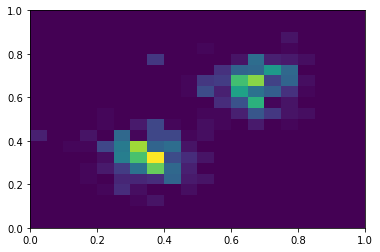

In [10]:
plt.figure()
plt.hist2d(sample[0][0][:, 0], sample[0][0][:, 1], range=[[0, 1], [0, 1]], bins=20)
plt.show()

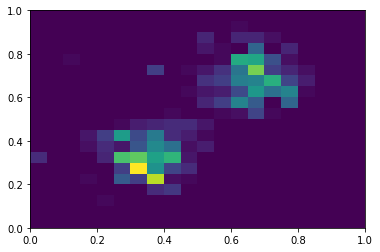

In [11]:
plt.figure()
plt.hist2d(sample[0][0][:, 0], sample[0][0][:, 2], range=[[0, 1], [0, 1]], bins=20)
plt.show()

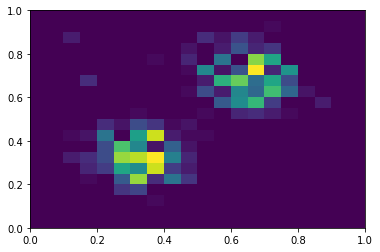

In [12]:
plt.figure()
plt.hist2d(sample[0][0][:, 1], sample[0][0][:, 2], range=[[0, 1], [0, 1]], bins=20)
plt.show()